In [1]:
import torch.nn.functional as Fun
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import random
random_seed = 100# 456  
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

In [2]:
class PizzaDataset(Dataset):
    def __init__(self, csv_file="train.csv", root="train_196", transform=None, target_transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        #print(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, img_path)
        image = Image.open(img_path)
        label = torch.tensor(int(self.labels.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
training_data = PizzaDataset(
    csv_file="train.csv",
    root="train_196",
    transform=transforms.ToTensor(),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = PizzaDataset(
    csv_file="labels.csv",
    root="test_196",
    transform=transforms.ToTensor(),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_45

Original Images


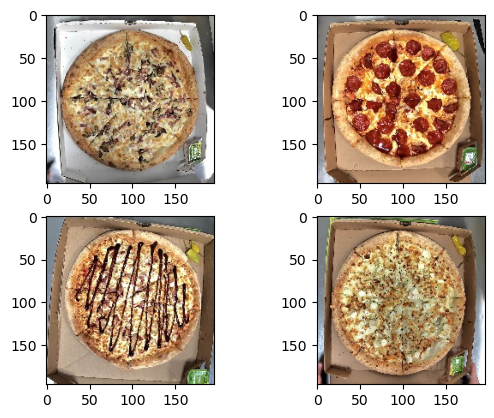

CutMix Images


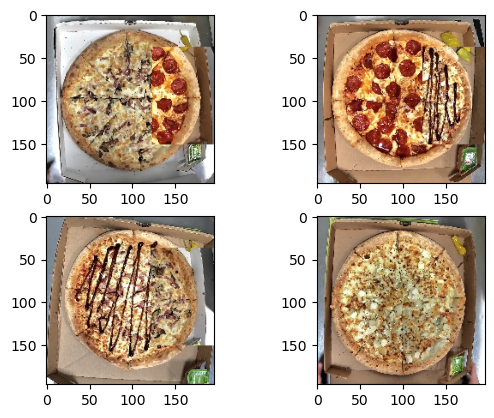

Original labels:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Updated labels
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [5]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label


# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

['альфредо', 'баварская', 'вегетарианская', 'ветчинаибекон', 'ветчинаигрибы', 'гавайская', 'грушаbbq', 'капричиоза', 'клубникаизефир', 'крем-чизсгрибами', 'любимаядедамороза', 'любимаякарбонара', 'любимаяпапинапицца', 'маленькаяиталия', 'маргарита', 'мексиканская', 'миксгрин', 'мясная', 'мясноебарбекю', 'новогодняя', 'палочки', 'папамикс', 'пепперони', 'пепперонигрин', 'пицца8сыровnew', 'постная', 'рождественская', 'сананасомибеконом', 'сгрушейибеконом', 'сгрушейиголубымсыром', 'сердцепепперони-4сыра', 'сердцецыпленокбарбекю-пепперони', 'сливочнаяскреветками', 'суперпапа', 'сырная', 'томатнаяскреветками', 'улыбка', 'цыпленокбарбекю', 'цыпленокгрин', 'цыпленоккордонблю', 'цыпленокрэнч', 'цыпленокфлорентина', 'чеддермексикан', 'чеддерчизбургер', 'четыресыра', 'чизбургер']


C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


TypeError: only integer tensors of a single element can be converted to an index

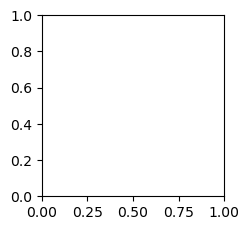

In [6]:
classes = """0: альфредо
1: баварская
2: вегетарианская
3: ветчинаибекон
4: ветчинаигрибы
5: гавайская
6: грушаbbq
7: капричиоза
8: клубникаизефир
9: крем-чизсгрибами
10: любимаядедамороза
11: любимаякарбонара
12: любимаяпапинапицца
13: маленькаяиталия
14: маргарита
15: мексиканская
16: миксгрин
17: мясная
18: мясноебарбекю
19: новогодняя
20: палочки
21: папамикс
22: пепперони
23: пепперонигрин
24: пицца8сыровnew
25: постная
26: рождественская
27: сананасомибеконом
28: сгрушейибеконом
29: сгрушейиголубымсыром
30: сердцепепперони-4сыра
31: сердцецыпленокбарбекю-пепперони
32: сливочнаяскреветками
33: суперпапа
34: сырная
35: томатнаяскреветками
36: улыбка
37: цыпленокбарбекю
38: цыпленокгрин
39: цыпленоккордонблю
40: цыпленокрэнч
41: цыпленокфлорентина
42: чеддермексикан
43: чеддерчизбургер
43: четыресыра
45: чизбургер"""

labels = classes.split()[1::2]
print(labels)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Случайный индекс из датасета
    img, label = training_data[sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(),0,-1))
plt.show()

In [7]:
img.numpy().shape

(3, 196, 196)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.cuda.empty_cache()

Using cuda device


In [9]:
from torchvision.models import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights

weights = RegNet_Y_3_2GF_Weights.DEFAULT
model = regnet_y_3_2gf(weights=weights)#preprocess is also here
model.to(device)
model.train()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [10]:
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = resnext50_32x4d(weights=weights)#preprocess is also here
model.to(device)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [12]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        X, y = generate_cutmix_image(X, y, 1.0)
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
def sent_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            preds.append(pred.cpu().numpy().argmax(1)[0])
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [16]:
learning_rate/=10
print(learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

0.0001


In [15]:
loss_list = []
acc_list = []

In [15]:
model = resnet50(weights=weights).eval()
state_dict = torch.load(checkpoint_filename)
model.load_state_dict(state_dict)
model.to(device)

NameError: name 'resnet50' is not defined

In [16]:
epochs = 20
print(torch.get_rng_state())
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

tensor([100,   0,   0,  ...,   0,   0,   0], dtype=torch.uint8)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_45

loss: 7.470887  [    0/ 6424]
loss: 2.767908  [  640/ 6424]
loss: 2.873102  [ 1280/ 6424]
loss: 2.402524  [ 1920/ 6424]
loss: 1.509255  [ 2560/ 6424]
loss: 1.890570  [ 3200/ 6424]
loss: 1.833209  [ 3840/ 6424]
loss: 1.844554  [ 4480/ 6424]
loss: 1.645469  [ 5120/ 6424]
loss: 1.207556  [ 5760/ 6424]
loss: 2.015605  [ 2400/ 6424]


C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:29<09:24, 29.71s/it]

Test Error: 
 Accuracy: 82.3%, Avg loss: 0.671726 

Epoch 2
-------------------------------
loss: 1.199791  [    0/ 6424]
loss: 0.279989  [  640/ 6424]
loss: 1.814579  [ 1280/ 6424]
loss: 0.918857  [ 1920/ 6424]
loss: 1.597207  [ 2560/ 6424]
loss: 0.378729  [ 3200/ 6424]
loss: 1.357903  [ 3840/ 6424]
loss: 1.094032  [ 4480/ 6424]
loss: 1.512711  [ 5120/ 6424]
loss: 1.226434  [ 5760/ 6424]
loss: 0.634755  [ 2400/ 6424]


 10%|████████▎                                                                          | 2/20 [00:51<07:34, 25.24s/it]

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.379019 

Epoch 3
-------------------------------
loss: 0.351008  [    0/ 6424]
loss: 1.282927  [  640/ 6424]
loss: 1.232617  [ 1280/ 6424]
loss: 1.217101  [ 1920/ 6424]
loss: 0.990797  [ 2560/ 6424]
loss: 1.286269  [ 3200/ 6424]
loss: 1.048369  [ 3840/ 6424]
loss: 1.143300  [ 4480/ 6424]
loss: 0.687890  [ 5120/ 6424]
loss: 1.160519  [ 5760/ 6424]
loss: 1.957901  [ 2400/ 6424]


 15%|████████████▍                                                                      | 3/20 [01:13<06:44, 23.80s/it]

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.290155 

Epoch 4
-------------------------------
loss: 0.834557  [    0/ 6424]
loss: 1.556062  [  640/ 6424]
loss: 2.006907  [ 1280/ 6424]
loss: 0.975337  [ 1920/ 6424]
loss: 0.874252  [ 2560/ 6424]
loss: 1.117118  [ 3200/ 6424]
loss: 1.308922  [ 3840/ 6424]
loss: 1.345318  [ 4480/ 6424]
loss: 0.565991  [ 5120/ 6424]
loss: 1.139775  [ 5760/ 6424]
loss: 1.147335  [ 2400/ 6424]


 20%|████████████████▌                                                                  | 4/20 [01:35<06:09, 23.12s/it]

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.369818 

Epoch 5
-------------------------------
loss: 1.075246  [    0/ 6424]
loss: 0.428715  [  640/ 6424]
loss: 0.705337  [ 1280/ 6424]
loss: 1.160761  [ 1920/ 6424]
loss: 1.115350  [ 2560/ 6424]
loss: 1.105660  [ 3200/ 6424]
loss: 0.888429  [ 3840/ 6424]
loss: 1.034357  [ 4480/ 6424]
loss: 1.106050  [ 5120/ 6424]
loss: 1.019231  [ 5760/ 6424]
loss: 0.689702  [ 2400/ 6424]


 25%|████████████████████▊                                                              | 5/20 [01:58<05:45, 23.04s/it]

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.284496 

Epoch 6
-------------------------------
loss: 0.197678  [    0/ 6424]
loss: 0.940177  [  640/ 6424]
loss: 1.061478  [ 1280/ 6424]
loss: 0.942336  [ 1920/ 6424]
loss: 0.969647  [ 2560/ 6424]
loss: 1.087949  [ 3200/ 6424]
loss: 0.913290  [ 3840/ 6424]
loss: 2.073252  [ 4480/ 6424]
loss: 1.042657  [ 5120/ 6424]
loss: 0.785766  [ 5760/ 6424]
loss: 1.387917  [ 2400/ 6424]


 30%|████████████████████████▉                                                          | 6/20 [02:21<05:21, 22.97s/it]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.257816 

Epoch 7
-------------------------------
loss: 0.794114  [    0/ 6424]
loss: 2.207120  [  640/ 6424]
loss: 0.668926  [ 1280/ 6424]
loss: 0.669030  [ 1920/ 6424]
loss: 1.051781  [ 2560/ 6424]
loss: 1.044535  [ 3200/ 6424]
loss: 0.466039  [ 3840/ 6424]
loss: 0.993790  [ 4480/ 6424]
loss: 1.009247  [ 5120/ 6424]
loss: 1.416300  [ 5760/ 6424]
loss: 1.147972  [ 2400/ 6424]


 35%|█████████████████████████████                                                      | 7/20 [02:43<04:55, 22.70s/it]

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.340178 

Epoch 8
-------------------------------
loss: 0.533612  [    0/ 6424]
loss: 0.161778  [  640/ 6424]
loss: 0.912373  [ 1280/ 6424]
loss: 1.608744  [ 1920/ 6424]
loss: 1.418774  [ 2560/ 6424]
loss: 1.519621  [ 3200/ 6424]
loss: 0.787607  [ 3840/ 6424]
loss: 1.072469  [ 4480/ 6424]
loss: 0.896561  [ 5120/ 6424]
loss: 0.858218  [ 5760/ 6424]
loss: 1.372424  [ 2400/ 6424]


 40%|█████████████████████████████████▏                                                 | 8/20 [03:05<04:30, 22.51s/it]

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.333212 

Epoch 9
-------------------------------
loss: 0.861791  [    0/ 6424]
loss: 0.829375  [  640/ 6424]
loss: 0.898989  [ 1280/ 6424]
loss: 0.733419  [ 1920/ 6424]
loss: 0.861562  [ 2560/ 6424]
loss: 0.828638  [ 3200/ 6424]
loss: 0.804858  [ 3840/ 6424]
loss: 0.718089  [ 4480/ 6424]
loss: 0.797202  [ 5120/ 6424]
loss: 0.592553  [ 5760/ 6424]
loss: 0.194242  [ 2400/ 6424]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:27<04:05, 22.35s/it]

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.234026 

Epoch 10
-------------------------------
loss: 0.677436  [    0/ 6424]
loss: 0.815098  [  640/ 6424]
loss: 1.315368  [ 1280/ 6424]
loss: 1.098533  [ 1920/ 6424]
loss: 1.118653  [ 2560/ 6424]
loss: 0.784573  [ 3200/ 6424]
loss: 1.210986  [ 3840/ 6424]
loss: 0.749905  [ 4480/ 6424]
loss: 0.922811  [ 5120/ 6424]
loss: 0.782938  [ 5760/ 6424]
loss: 0.990317  [ 2400/ 6424]


 50%|█████████████████████████████████████████                                         | 10/20 [03:49<03:42, 22.21s/it]

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.227935 

Epoch 11
-------------------------------
loss: 0.888996  [    0/ 6424]
loss: 0.429782  [  640/ 6424]
loss: 1.047857  [ 1280/ 6424]
loss: 0.921844  [ 1920/ 6424]
loss: 0.158967  [ 2560/ 6424]
loss: 0.543700  [ 3200/ 6424]
loss: 0.846456  [ 3840/ 6424]
loss: 0.699549  [ 4480/ 6424]
loss: 0.922673  [ 5120/ 6424]
loss: 1.093217  [ 5760/ 6424]
loss: 0.515259  [ 2400/ 6424]


 55%|█████████████████████████████████████████████                                     | 11/20 [04:11<03:19, 22.11s/it]

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.378541 

Epoch 12
-------------------------------
loss: 0.932456  [    0/ 6424]
loss: 1.702833  [  640/ 6424]
loss: 0.667019  [ 1280/ 6424]
loss: 0.806498  [ 1920/ 6424]
loss: 0.716550  [ 2560/ 6424]
loss: 0.431868  [ 3200/ 6424]
loss: 0.767177  [ 3840/ 6424]
loss: 0.760500  [ 4480/ 6424]
loss: 1.257967  [ 5120/ 6424]
loss: 1.252017  [ 5760/ 6424]
loss: 0.987648  [ 2400/ 6424]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:33<02:56, 22.06s/it]

Test Error: 
 Accuracy: 94.3%, Avg loss: 0.313254 

Epoch 13
-------------------------------
loss: 1.601393  [    0/ 6424]
loss: 0.897444  [  640/ 6424]
loss: 0.808352  [ 1280/ 6424]
loss: 0.689606  [ 1920/ 6424]
loss: 0.924579  [ 2560/ 6424]
loss: 0.833748  [ 3200/ 6424]
loss: 0.235902  [ 3840/ 6424]
loss: 0.316978  [ 4480/ 6424]
loss: 1.505472  [ 5120/ 6424]
loss: 0.849011  [ 5760/ 6424]
loss: 0.804645  [ 2400/ 6424]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:55<02:34, 22.03s/it]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.245081 

Epoch 14
-------------------------------
loss: 0.676357  [    0/ 6424]
loss: 1.055133  [  640/ 6424]
loss: 0.559438  [ 1280/ 6424]
loss: 0.782023  [ 1920/ 6424]
loss: 0.770520  [ 2560/ 6424]
loss: 0.745711  [ 3200/ 6424]
loss: 0.815528  [ 3840/ 6424]
loss: 0.914587  [ 4480/ 6424]
loss: 0.807945  [ 5120/ 6424]
loss: 0.654429  [ 5760/ 6424]
loss: 0.737212  [ 2400/ 6424]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:17<02:12, 22.03s/it]

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.226132 

Epoch 15
-------------------------------
loss: 0.829828  [    0/ 6424]
loss: 0.779765  [  640/ 6424]
loss: 0.834945  [ 1280/ 6424]
loss: 1.296793  [ 1920/ 6424]
loss: 1.433315  [ 2560/ 6424]
loss: 0.859835  [ 3200/ 6424]
loss: 1.483824  [ 3840/ 6424]
loss: 1.371977  [ 4480/ 6424]
loss: 1.193312  [ 5120/ 6424]
loss: 0.820575  [ 5760/ 6424]
loss: 0.692346  [ 2400/ 6424]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:39<01:50, 22.00s/it]

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.246555 

Epoch 16
-------------------------------
loss: 0.792053  [    0/ 6424]
loss: 0.388157  [  640/ 6424]
loss: 0.912130  [ 1280/ 6424]
loss: 0.554912  [ 1920/ 6424]
loss: 0.828357  [ 2560/ 6424]
loss: 0.755727  [ 3200/ 6424]
loss: 0.608596  [ 3840/ 6424]
loss: 0.718891  [ 4480/ 6424]
loss: 0.856474  [ 5120/ 6424]
loss: 1.252341  [ 5760/ 6424]
loss: 0.744641  [ 2400/ 6424]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [06:01<01:27, 21.99s/it]

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.280591 

Epoch 17
-------------------------------
loss: 0.677452  [    0/ 6424]
loss: 0.448550  [  640/ 6424]
loss: 1.214970  [ 1280/ 6424]
loss: 0.625902  [ 1920/ 6424]
loss: 0.844029  [ 2560/ 6424]
loss: 0.772892  [ 3200/ 6424]
loss: 0.677649  [ 3840/ 6424]
loss: 0.432935  [ 4480/ 6424]
loss: 0.805019  [ 5120/ 6424]
loss: 0.734994  [ 5760/ 6424]
loss: 0.707774  [ 2400/ 6424]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:23<01:05, 21.99s/it]

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.212666 

Epoch 18
-------------------------------
loss: 0.929744  [    0/ 6424]
loss: 0.932151  [  640/ 6424]
loss: 0.720962  [ 1280/ 6424]
loss: 0.702470  [ 1920/ 6424]
loss: 0.231412  [ 2560/ 6424]
loss: 0.633740  [ 3200/ 6424]
loss: 0.654548  [ 3840/ 6424]
loss: 0.593628  [ 4480/ 6424]
loss: 1.314209  [ 5120/ 6424]
loss: 0.714505  [ 5760/ 6424]
loss: 0.872116  [ 2400/ 6424]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:45<00:43, 21.99s/it]

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.204760 

Epoch 19
-------------------------------
loss: 0.684670  [    0/ 6424]
loss: 1.022174  [  640/ 6424]
loss: 0.697600  [ 1280/ 6424]
loss: 0.728565  [ 1920/ 6424]
loss: 0.966267  [ 2560/ 6424]
loss: 0.968208  [ 3200/ 6424]
loss: 0.766226  [ 3840/ 6424]
loss: 0.667870  [ 4480/ 6424]
loss: 0.620592  [ 5120/ 6424]
loss: 0.701663  [ 5760/ 6424]
loss: 0.540557  [ 2400/ 6424]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:07<00:21, 21.98s/it]

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.202343 

Epoch 20
-------------------------------
loss: 1.550893  [    0/ 6424]
loss: 0.830720  [  640/ 6424]
loss: 0.671991  [ 1280/ 6424]
loss: 0.643494  [ 1920/ 6424]
loss: 0.815156  [ 2560/ 6424]
loss: 1.626179  [ 3200/ 6424]
loss: 0.566847  [ 3840/ 6424]
loss: 0.988846  [ 4480/ 6424]
loss: 0.655152  [ 5120/ 6424]
loss: 1.116259  [ 5760/ 6424]
loss: 0.944646  [ 2400/ 6424]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:29<00:00, 22.48s/it]

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.232193 

Done!


In [17]:
learning_rate = 1e-4
print(torch.get_rng_state())
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 4
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

tensor([100,   0,   0,  ...,   0,   0,   0], dtype=torch.uint8)


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_45

loss: 0.722404  [    0/ 6424]
loss: 0.681596  [  640/ 6424]
loss: 0.055365  [ 1280/ 6424]
loss: 0.762187  [ 1920/ 6424]
loss: 1.678555  [ 2560/ 6424]
loss: 0.768876  [ 3200/ 6424]
loss: 0.674567  [ 3840/ 6424]
loss: 0.647480  [ 4480/ 6424]
loss: 0.506986  [ 5120/ 6424]
loss: 0.622010  [ 5760/ 6424]
loss: 0.737616  [ 2400/ 6424]


C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
 25%|█████████████████████                                                               | 1/4 [00:21<01:05, 21.94s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.174801 

Epoch 2
-------------------------------
loss: 0.736341  [    0/ 6424]
loss: 0.573254  [  640/ 6424]
loss: 0.669365  [ 1280/ 6424]
loss: 0.647641  [ 1920/ 6424]
loss: 0.724651  [ 2560/ 6424]
loss: 0.578219  [ 3200/ 6424]
loss: 0.424667  [ 3840/ 6424]
loss: 0.111898  [ 4480/ 6424]
loss: 0.476454  [ 5120/ 6424]
loss: 0.947791  [ 5760/ 6424]
loss: 0.773832  [ 2400/ 6424]


 50%|██████████████████████████████████████████                                          | 2/4 [00:43<00:43, 21.97s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.178913 

Epoch 3
-------------------------------
loss: 0.600828  [    0/ 6424]
loss: 0.789133  [  640/ 6424]
loss: 1.255723  [ 1280/ 6424]
loss: 0.820469  [ 1920/ 6424]
loss: 0.693192  [ 2560/ 6424]
loss: 0.694654  [ 3200/ 6424]
loss: 0.175304  [ 3840/ 6424]
loss: 0.757462  [ 4480/ 6424]
loss: 0.749133  [ 5120/ 6424]
loss: 0.665363  [ 5760/ 6424]
loss: 0.812638  [ 2400/ 6424]


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:05<00:21, 21.96s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.168499 

Epoch 4
-------------------------------
loss: 0.568918  [    0/ 6424]
loss: 0.738046  [  640/ 6424]
loss: 0.629844  [ 1280/ 6424]
loss: 0.965232  [ 1920/ 6424]
loss: 0.728235  [ 2560/ 6424]
loss: 0.738618  [ 3200/ 6424]
loss: 0.372121  [ 3840/ 6424]
loss: 0.726490  [ 4480/ 6424]
loss: 0.650028  [ 5120/ 6424]
loss: 0.133466  [ 5760/ 6424]
loss: 1.185668  [ 2400/ 6424]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:27<00:00, 21.97s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.163977 

Done!


In [17]:
learning_rate = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_22104\2055696679.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_22104\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_

loss: 0.597400  [    0/ 6424]
loss: 0.665237  [  640/ 6424]
loss: 0.211711  [ 1280/ 6424]
loss: 0.604051  [ 1920/ 6424]
loss: 0.636186  [ 2560/ 6424]
loss: 0.735098  [ 3200/ 6424]
loss: 1.212303  [ 3840/ 6424]
loss: 0.655630  [ 4480/ 6424]
loss: 0.520181  [ 5120/ 6424]
loss: 0.874580  [ 5760/ 6424]
loss: 0.807416  [ 2400/ 6424]


C:\Users\Артур\AppData\Local\Temp\ipykernel_22104\2055696679.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:22<06:58, 22.04s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.159045 

Epoch 2
-------------------------------
loss: 0.519051  [    0/ 6424]
loss: 0.637968  [  640/ 6424]
loss: 0.705917  [ 1280/ 6424]
loss: 0.598555  [ 1920/ 6424]
loss: 0.387984  [ 2560/ 6424]
loss: 0.357077  [ 3200/ 6424]
loss: 0.564048  [ 3840/ 6424]
loss: 0.458114  [ 4480/ 6424]
loss: 0.769857  [ 5120/ 6424]
loss: 0.662424  [ 5760/ 6424]
loss: 0.378186  [ 2400/ 6424]


 10%|████████▎                                                                          | 2/20 [00:44<06:36, 22.03s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.161433 

Epoch 3
-------------------------------
loss: 0.661076  [    0/ 6424]
loss: 0.416905  [  640/ 6424]
loss: 0.553200  [ 1280/ 6424]
loss: 0.577201  [ 1920/ 6424]
loss: 0.167040  [ 2560/ 6424]
loss: 0.284659  [ 3200/ 6424]
loss: 0.558663  [ 3840/ 6424]
loss: 0.638615  [ 4480/ 6424]
loss: 0.359068  [ 5120/ 6424]
loss: 0.137479  [ 5760/ 6424]
loss: 0.614655  [ 2400/ 6424]


 15%|████████████▍                                                                      | 3/20 [01:06<06:14, 22.02s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.162715 

Epoch 4
-------------------------------
loss: 0.648553  [    0/ 6424]
loss: 0.568903  [  640/ 6424]
loss: 0.790741  [ 1280/ 6424]
loss: 0.554935  [ 1920/ 6424]
loss: 0.720596  [ 2560/ 6424]
loss: 0.652094  [ 3200/ 6424]
loss: 0.684010  [ 3840/ 6424]
loss: 0.451017  [ 4480/ 6424]
loss: 1.025639  [ 5120/ 6424]
loss: 0.579394  [ 5760/ 6424]
loss: 0.813832  [ 2400/ 6424]


 20%|████████████████▌                                                                  | 4/20 [01:28<05:52, 22.02s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.162192 

Epoch 5
-------------------------------
loss: 0.652634  [    0/ 6424]
loss: 0.749581  [  640/ 6424]
loss: 0.335438  [ 1280/ 6424]
loss: 0.649147  [ 1920/ 6424]
loss: 0.633189  [ 2560/ 6424]
loss: 0.543816  [ 3200/ 6424]
loss: 0.583423  [ 3840/ 6424]
loss: 0.558644  [ 4480/ 6424]
loss: 0.533896  [ 5120/ 6424]
loss: 0.665416  [ 5760/ 6424]
loss: 0.633616  [ 2400/ 6424]


 25%|████████████████████▊                                                              | 5/20 [01:50<05:30, 22.01s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.160184 

Epoch 6
-------------------------------
loss: 0.723320  [    0/ 6424]
loss: 0.681900  [  640/ 6424]
loss: 0.656993  [ 1280/ 6424]
loss: 0.550585  [ 1920/ 6424]
loss: 0.608135  [ 2560/ 6424]
loss: 0.423655  [ 3200/ 6424]
loss: 0.593980  [ 3840/ 6424]
loss: 0.060390  [ 4480/ 6424]
loss: 0.487141  [ 5120/ 6424]
loss: 0.696753  [ 5760/ 6424]
loss: 0.560646  [ 2400/ 6424]


 30%|████████████████████████▉                                                          | 6/20 [02:12<05:08, 22.02s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.158023 

Epoch 7
-------------------------------
loss: 0.711447  [    0/ 6424]
loss: 0.268485  [  640/ 6424]
loss: 1.601284  [ 1280/ 6424]
loss: 0.697183  [ 1920/ 6424]
loss: 0.748469  [ 2560/ 6424]
loss: 0.627260  [ 3200/ 6424]
loss: 0.683443  [ 3840/ 6424]
loss: 0.426491  [ 4480/ 6424]
loss: 0.736919  [ 5120/ 6424]
loss: 0.220685  [ 5760/ 6424]
loss: 0.665002  [ 2400/ 6424]


 35%|█████████████████████████████                                                      | 7/20 [02:34<04:46, 22.02s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.159946 

Epoch 8
-------------------------------
loss: 0.579916  [    0/ 6424]
loss: 0.611814  [  640/ 6424]
loss: 0.706945  [ 1280/ 6424]
loss: 0.415337  [ 1920/ 6424]
loss: 0.521843  [ 2560/ 6424]
loss: 0.707663  [ 3200/ 6424]
loss: 0.692470  [ 3840/ 6424]
loss: 0.532091  [ 4480/ 6424]
loss: 0.491765  [ 5120/ 6424]
loss: 0.566176  [ 5760/ 6424]
loss: 0.680459  [ 2400/ 6424]


 40%|█████████████████████████████████▏                                                 | 8/20 [02:56<04:24, 22.01s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.161901 

Epoch 9
-------------------------------
loss: 0.544150  [    0/ 6424]
loss: 0.537392  [  640/ 6424]
loss: 0.727345  [ 1280/ 6424]
loss: 0.465894  [ 1920/ 6424]
loss: 0.485470  [ 2560/ 6424]
loss: 0.558605  [ 3200/ 6424]
loss: 0.799965  [ 3840/ 6424]
loss: 0.582598  [ 4480/ 6424]
loss: 0.212482  [ 5120/ 6424]
loss: 0.470999  [ 5760/ 6424]
loss: 0.708954  [ 2400/ 6424]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:18<04:02, 22.03s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.159570 

Epoch 10
-------------------------------
loss: 0.509043  [    0/ 6424]
loss: 0.555034  [  640/ 6424]
loss: 0.736831  [ 1280/ 6424]
loss: 0.622827  [ 1920/ 6424]
loss: 0.594876  [ 2560/ 6424]
loss: 0.561380  [ 3200/ 6424]
loss: 0.549847  [ 3840/ 6424]
loss: 0.671221  [ 4480/ 6424]
loss: 0.682615  [ 5120/ 6424]
loss: 0.571998  [ 5760/ 6424]
loss: 0.591332  [ 2400/ 6424]


 50%|█████████████████████████████████████████                                         | 10/20 [03:40<03:40, 22.04s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.157503 

Epoch 11
-------------------------------
loss: 1.353209  [    0/ 6424]
loss: 0.613915  [  640/ 6424]
loss: 0.554306  [ 1280/ 6424]
loss: 0.665920  [ 1920/ 6424]
loss: 0.570305  [ 2560/ 6424]
loss: 0.421861  [ 3200/ 6424]
loss: 0.514119  [ 3840/ 6424]
loss: 0.679828  [ 4480/ 6424]
loss: 0.755461  [ 5120/ 6424]
loss: 0.539852  [ 5760/ 6424]
loss: 0.353890  [ 2400/ 6424]


 55%|█████████████████████████████████████████████                                     | 11/20 [04:02<03:18, 22.03s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.158957 

Epoch 12
-------------------------------
loss: 0.654237  [    0/ 6424]
loss: 0.611477  [  640/ 6424]
loss: 0.715237  [ 1280/ 6424]
loss: 0.485339  [ 1920/ 6424]
loss: 0.658490  [ 2560/ 6424]
loss: 0.641366  [ 3200/ 6424]
loss: 0.805122  [ 3840/ 6424]
loss: 0.671501  [ 4480/ 6424]
loss: 0.638152  [ 5120/ 6424]
loss: 0.520566  [ 5760/ 6424]
loss: 0.506288  [ 2400/ 6424]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:24<02:56, 22.03s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.159271 

Epoch 13
-------------------------------
loss: 0.715102  [    0/ 6424]
loss: 0.575866  [  640/ 6424]
loss: 0.850228  [ 1280/ 6424]
loss: 0.704919  [ 1920/ 6424]
loss: 0.392155  [ 2560/ 6424]
loss: 0.647046  [ 3200/ 6424]
loss: 0.614290  [ 3840/ 6424]
loss: 1.185454  [ 4480/ 6424]
loss: 0.429139  [ 5120/ 6424]
loss: 0.692465  [ 5760/ 6424]
loss: 0.720456  [ 2400/ 6424]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:46<02:34, 22.04s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.158507 

Epoch 14
-------------------------------
loss: 0.624220  [    0/ 6424]
loss: 0.665437  [  640/ 6424]
loss: 0.592601  [ 1280/ 6424]
loss: 0.646425  [ 1920/ 6424]
loss: 0.691457  [ 2560/ 6424]
loss: 0.719177  [ 3200/ 6424]
loss: 0.652339  [ 3840/ 6424]
loss: 0.707613  [ 4480/ 6424]
loss: 0.507544  [ 5120/ 6424]
loss: 0.497480  [ 5760/ 6424]
loss: 0.540048  [ 2400/ 6424]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:08<02:12, 22.05s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.157722 

Epoch 15
-------------------------------
loss: 0.521098  [    0/ 6424]
loss: 0.430787  [  640/ 6424]
loss: 0.517254  [ 1280/ 6424]
loss: 0.625676  [ 1920/ 6424]
loss: 0.821066  [ 2560/ 6424]
loss: 0.393147  [ 3200/ 6424]
loss: 1.011123  [ 3840/ 6424]
loss: 0.702389  [ 4480/ 6424]
loss: 0.652043  [ 5120/ 6424]
loss: 0.497742  [ 5760/ 6424]
loss: 0.617772  [ 2400/ 6424]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:30<01:50, 22.05s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.157487 

Epoch 16
-------------------------------
loss: 0.571632  [    0/ 6424]
loss: 0.603224  [  640/ 6424]
loss: 0.717122  [ 1280/ 6424]
loss: 0.331021  [ 1920/ 6424]
loss: 0.635123  [ 2560/ 6424]
loss: 0.238717  [ 3200/ 6424]
loss: 0.849337  [ 3840/ 6424]
loss: 0.150026  [ 4480/ 6424]
loss: 0.685064  [ 5120/ 6424]
loss: 0.721281  [ 5760/ 6424]
loss: 0.426628  [ 2400/ 6424]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:52<01:28, 22.04s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.156003 

Epoch 17
-------------------------------
loss: 0.702198  [    0/ 6424]
loss: 0.720413  [  640/ 6424]
loss: 0.516286  [ 1280/ 6424]
loss: 0.661396  [ 1920/ 6424]
loss: 0.545931  [ 2560/ 6424]
loss: 0.523915  [ 3200/ 6424]
loss: 0.507981  [ 3840/ 6424]
loss: 0.575342  [ 4480/ 6424]
loss: 0.588185  [ 5120/ 6424]
loss: 0.522260  [ 5760/ 6424]
loss: 0.737779  [ 2400/ 6424]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:14<01:06, 22.05s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.159139 

Epoch 18
-------------------------------
loss: 0.368126  [    0/ 6424]
loss: 0.880545  [  640/ 6424]
loss: 0.190946  [ 1280/ 6424]
loss: 0.734745  [ 1920/ 6424]
loss: 0.343447  [ 2560/ 6424]
loss: 0.680603  [ 3200/ 6424]
loss: 0.693366  [ 3840/ 6424]
loss: 1.275001  [ 4480/ 6424]
loss: 0.751035  [ 5120/ 6424]
loss: 0.725544  [ 5760/ 6424]
loss: 0.973360  [ 2400/ 6424]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:36<00:44, 22.05s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.158293 

Epoch 19
-------------------------------
loss: 0.894880  [    0/ 6424]
loss: 0.757186  [  640/ 6424]
loss: 0.640460  [ 1280/ 6424]
loss: 0.676537  [ 1920/ 6424]
loss: 0.550035  [ 2560/ 6424]
loss: 0.629792  [ 3200/ 6424]
loss: 0.685472  [ 3840/ 6424]
loss: 0.699951  [ 4480/ 6424]
loss: 0.536440  [ 5120/ 6424]
loss: 0.648709  [ 5760/ 6424]
loss: 0.593251  [ 2400/ 6424]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [06:58<00:22, 22.05s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.158144 

Epoch 20
-------------------------------
loss: 0.663107  [    0/ 6424]
loss: 0.386818  [  640/ 6424]
loss: 0.722945  [ 1280/ 6424]
loss: 0.705098  [ 1920/ 6424]
loss: 0.519092  [ 2560/ 6424]
loss: 0.531649  [ 3200/ 6424]
loss: 0.524613  [ 3840/ 6424]
loss: 0.710749  [ 4480/ 6424]
loss: 0.703987  [ 5120/ 6424]
loss: 0.259210  [ 5760/ 6424]
loss: 0.677383  [ 2400/ 6424]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:20<00:00, 22.04s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.158616 

Done!


In [66]:
checkpoint_filename = "my_model.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [84]:
checkpoint_filename = "my_model1.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [90]:
checkpoint_filename = "my_model2.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [48]:
checkpoint_filename = "my_modelresxbest.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [61]:
checkpoint_filename = "my_modelresxbest1.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [20]:
checkpoint_filename = "my_modelfirstreg.pt"
torch.save(model.state_dict(), checkpoint_filename)

In [62]:
from torchvision.models import resnext50_32x4d
new_model = resnext50_32x4d().eval()
state_dict = torch.load("my_modelresxbest1.pt")
new_model.load_state_dict(state_dict)
new_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [63]:
new_model.train(False)
preds = sent_loop(sent_dataloader, new_model, loss_fn)

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.448411 



0.020131086142322098


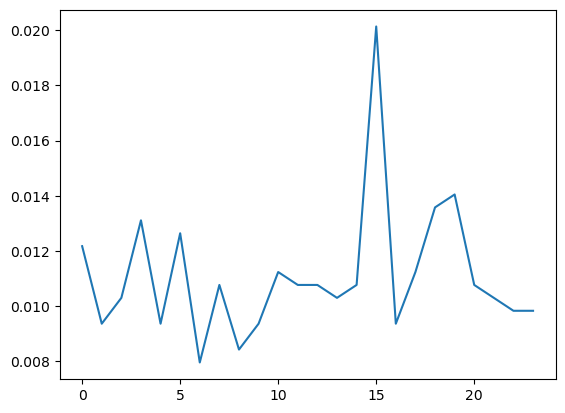

In [20]:
print(max(acc_list))
plt.plot(acc_list)

0.9653558052434457


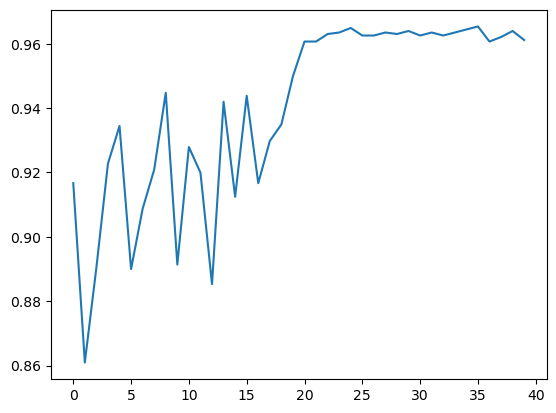

In [17]:
print(max(acc_list))
plt.plot(acc_list)

In [20]:
print(np.argmax(np.array(acc_list)))
#print(acc_list[60])

37


In [18]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
preds = sent_loop(sent_dataloader, model, loss_fn)

C:\Users\Артур\AppData\Local\Temp\ipykernel_4592\2055696679.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 97.7%, Avg loss: 0.166409 



In [20]:
print(len(preds))
d = {'id': np.arange(0,2136), 'label1': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('pred1.csv', index=False, header=True)

2136
        id  label1
0        0       0
1        1       0
2        2       0
3        3       0
4        4       0
...    ...     ...
2131  2131      45
2132  2132      45
2133  2133      45
2134  2134      45
2135  2135      45

[2136 rows x 2 columns]


In [54]:
tdf=df[(df['label']==0) | (df['label']==41) | (df['label']==38)]
print(tdf)
tdf.to_csv('alfredotrain.csv', index=False, header=True)

        id  label
0        0      0
1        1      0
2        2      0
3        3      0
4        4      0
...    ...    ...
1972  1972     41
1973  1973     41
1974  1974     41
1975  1975     41
1976  1976     38

[108 rows x 2 columns]


In [56]:
tf=pd.read_csv('labels.csv')
print(tf[(tf['label']==0) | (tf['label']==41) | (tf['label']==38)])

        id     image_name  label
0        0  test_0000.jpg      0
1        1  test_0001.jpg      0
2        2  test_0002.jpg      0
3        3  test_0003.jpg      0
4        4  test_0004.jpg      0
...    ...            ...    ...
1972  1972  test_1972.jpg     41
1973  1973  test_1973.jpg     41
1974  1974  test_1974.jpg     41
1975  1975  test_1975.jpg     41
1976  1976  test_1976.jpg     41

[107 rows x 3 columns]


In [45]:
def check_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    rawpreds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            rawpreds.append(np.flip(np.argsort(pred.cpu().numpy()[0]))[:5])
            preds.append(pred.cpu().numpy().argmax(1)[0])
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds, rawpreds

In [46]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
preds, raws = check_loop(sent_dataloader, model, loss_fn)
dc = {'id': np.arange(0,2136), 'label': preds, 'preds': raws}
dfc=pd.DataFrame(data=dc)
print(dfc)
dfc.to_csv('check.csv', index=False, header=True)

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.358855 

        id  label                 preds
0        0      0    [0, 41, 39, 7, 11]
1        1      0     [0, 4, 7, 45, 11]
2        2      0    [0, 11, 41, 45, 7]
3        3      0     [0, 7, 4, 40, 41]
4        4      0     [0, 39, 41, 4, 7]
...    ...    ...                   ...
2131  2131     45     [45, 38, 3, 7, 4]
2132  2132     45  [45, 43, 38, 15, 11]
2133  2133     45     [45, 43, 3, 9, 1]
2134  2134     45   [45, 43, 15, 9, 38]
2135  2135     45   [45, 43, 9, 16, 15]

[2136 rows x 3 columns]
